In [1654]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.fft import rfft, irfft, rfftfreq

In [1655]:
input_pos = input("Enter Position: ")
input_deg = input("Enter Angle: ")

### Laden der Daten anhand der gegebenen Position und Messwinkel

In [1656]:
def find_matching_files(file_list, angle, position):
    for file in file_list:
        if f"angle_{angle}" in file and f"pos_{position}" in file:
            matching_file = os.path.join(folder_path, file)
            filename = file
      
            
    return (matching_file, filename)


folder_path = os.path.join(os.getcwd(), 'Logs')
files = os.listdir(folder_path)
file = find_matching_files(files, input_deg, input_pos)
scan_df = pd.read_csv(file[0])
data_df = scan_df.iloc[:, :-3]

In [1657]:
#data_df[data_df['shape'] == 'pentagon'].to_csv('data_test_pentagon_2.csv', index=False)

In [1658]:
file

('c:\\Users\\richa\\Documents\\PyESP\\Logs\\scans_angle_2_8125_pos_6_rot_1.csv',
 'scans_angle_2_8125_pos_6_rot_1.csv')

In [1659]:
data_df

,0.0,2.8125,5.625,8.4375,11.25,14.0625,16.875,19.6875,22.5,25.3125,...,334.6875,337.5,340.3125,343.125,345.9375,348.75,351.5625,354.375,357.1875,shape
0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,100.0,99.0,cylinder
1,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,100.0,99.0,99.0,99.0,99.0,99.0,cylinder
2,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,cylinder
3,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,cylinder
4,99.0,100.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,cylinder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,178.0,120.0,99.0,110.0,106.0,103.0,103.0,99.0,99.0,103.0,...,204.0,191.0,191.0,191.0,162.0,204.0,217.0,570.0,226.0,cube
796,120.0,99.0,110.0,106.0,103.0,100.0,99.0,99.0,103.0,110.0,...,162.0,191.0,191.0,162.0,217.0,204.0,570.0,213.0,178.0,cube
797,99.0,113.0,110.0,107.0,103.0,99.0,99.0,103.0,110.0,113.0,...,191.0,191.0,162.0,229.0,217.0,238.0,226.0,145.0,120.0,cube
798,110.0,106.0,103.0,99.0,99.0,103.0,106.0,110.0,113.0,99.0,...,191.0,162.0,229.0,204.0,570.0,200.0,145.0,117.0,99.0,cube


### Helferfunktion, die den String-Header in einen Numpy-Array mit float-Werten umwandelt


In [1660]:
def header_to_int(df: pd.DataFrame):
    columns = df.iloc[:, :-1].columns.values
    columns_int = np.array([float(column) for column in columns])
    return columns_int

### Helferfunktion, die anhand der Messwerte des Zylinders, der indirekt als Kalibrierungsobjekt dient, den Abstand eines jeden Messpunktes zum Mittelpunkt der Messplatte berechnet

In [1661]:
def get_dist_middlepoint(df: pd.DataFrame):
    diameter_cylinder = 50
    grouped = df.groupby('shape').mean()
    distance_to_middle = grouped.loc['cylinder', :].values.mean() + diameter_cylinder/2
    distance_object_middle_to_edge = distance_to_middle - grouped.loc['cylinder', :].values
    print(distance_to_middle)
    return distance_object_middle_to_edge

dist = get_dist_middlepoint(data_df)   

124.03505228136882


### Helferfunktion, die den maximal möglichen Messwert berechnet

In [1662]:
def get_max_possible_dist(df: pd.DataFrame):
    diameter_cylinder = 50
    cylinder_measurement = df.groupby('shape').mean().loc['cylinder', :].values.mean()

    return diameter_cylinder/2 + cylinder_measurement

max_dist = get_max_possible_dist(data_df)

In [1663]:
max_dist

124.03505228136882

## Bereinigen der Messdaten
Das Bereinigen der Messdaten beginnt mit dem Ersetzen aller Werte, die den Maximalwert überschreiten mit NaN

In [1664]:
def normalize_minus_one_to_one(array):
    return 2 * ((array - np.min(array)) / (np.max(array) - np.min(array))) - 1

In [1665]:
def fft_filter(row, cutoff=0.07):
    # FFT der Zeile
    fft_coeffs = rfft(row)
    fft_freqs = rfftfreq(len(row))
    
    # Filter: Entfernen hochfrequenter Komponenten
    low_pass_filter = fft_freqs < cutoff
    filtered_fft_coeffs = fft_coeffs * low_pass_filter
    
    # Rücktransformation in den Zeitbereich
    filtered_row = irfft(filtered_fft_coeffs)
    return filtered_row

In [1666]:
values_df = data_df.iloc[:, :-1]

In [1667]:
median_window_size = 11 if input_deg == '2' else 3


data_filtered_df = pd.DataFrame()
data_filter = pd.DataFrame()
for i in range(len(data_df)):
    data_filtered = medfilt(values_df.iloc[i], kernel_size=median_window_size)
    data_filtered_fft_int = fft_filter(data_filtered)
    data_filtered_df= pd.concat([data_filtered_df, pd.DataFrame(data_filtered_fft_int).T], axis=0, ignore_index=True)
    data_filter = pd.concat([data_filter, pd.DataFrame(data_filtered).T], axis=0, ignore_index=True)
    


data_filtered_df.columns = data_df.columns[:-1]
data_filter.columns = data_df.columns[:-1]
#data_df_filtered_diff = data_df_filtered.apply(lambda x: np.gradient(x))
data_filtered_df_diff = data_filtered_df.diff(axis=1)
data_filtered_df_diff = data_filtered_df_diff.apply(lambda x: normalize_minus_one_to_one(x), axis=1)
data_filtered_df_diff = data_filtered_df_diff.apply(lambda x: x-np.mean(x), axis=1)
data_filtered_df_diff.fillna(0, inplace=True)
data_filtered_df['shape'] = data_df['shape']
data_filtered_df_diff['shape'] = data_df['shape']
data_filter['shape'] = data_df['shape']


<Axes: >

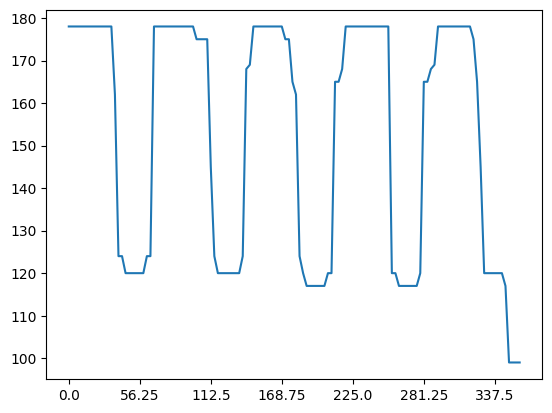

In [1668]:
data_filter[data_filter['shape'] == 'pentagon'].iloc[2,:-1].plot()

In [1669]:
file[1].replace('.csv', '')

'scans_angle_2_8125_pos_6_rot_1'

In [1670]:
# data_filtered_df.to_csv(f"Filtered_Data\\{file[1].replace('.csv', '')}_filtered.csv", index=False)

In [1671]:
# data_filtered_df_diff.to_csv(f"Normalized_Data\\{file[1].replace('.csv', '')}_normalized.csv", index=False)

<Axes: >

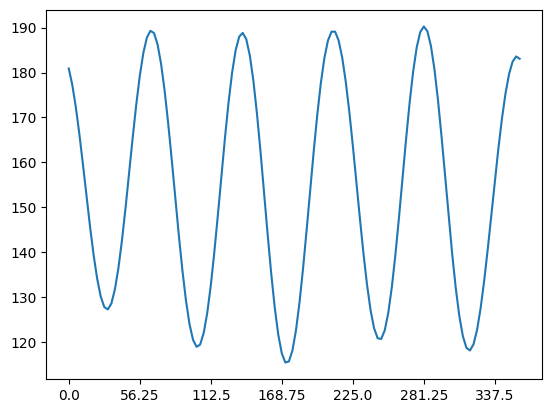

In [1672]:
data_filtered_df[data_filtered_df['shape'] == 'pentagon'].iloc[10,:-1].plot()

<Axes: >

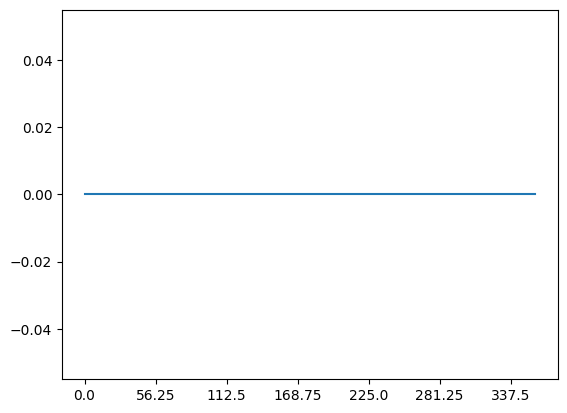

In [1673]:
data_filtered_df_diff[data_filtered_df_diff['shape'] == 'cylinder'].iloc[0,:-1].plot()

In [1674]:
# angles = np.array([float(angle) for angle in data_df.columns[:-1]])

# target_angles = np.linspace(0, 360, 512, endpoint=False)

# df_interpolated = pd.DataFrame()

# for index, row in data_df.iterrows():
#     values = row[:-1].values
    
#     interpolation_function = interp1d(angles, values, kind='linear', fill_value="extrapolate")
    
#     interpolated_values = interpolation_function(target_angles)
    
#     df_interpolated = pd.concat([df_interpolated, pd.DataFrame(interpolated_values).T], axis=0, ignore_index=True)
#     #df_interpolated.append(pd.Series(interpolated_values), ignore_index=True)

# df_interpolated['shape'] = data_df['shape']

# new_columns = [f"{angle:.3f}" for angle in target_angles] + ['shape']
# df_interpolated.columns = new_columns


In [1675]:
# df_interpolated

In [1676]:
# for column in data_df.columns:
#     if column != 'shape':
#         data_df[column] = data_df[column].apply(lambda x: x if x <= max_dist else np.nan)


In [1677]:
# data_df[data_df['shape'] == 'prisma'].iloc[20,:-1].plot()

## Plot der Ergebnisse in einem Polarplot

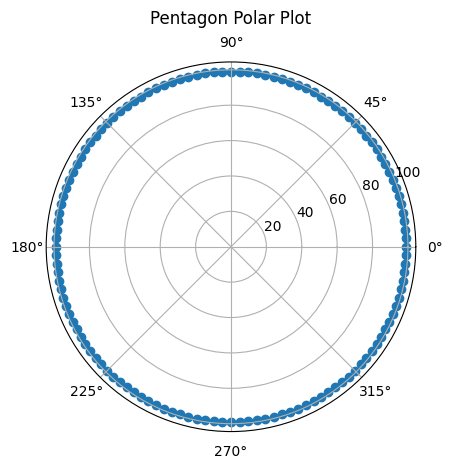

In [1678]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(header_to_int(data_df)*np.pi / 180, data_filtered_df[data_filtered_df['shape'] == 'cylinder'].iloc[2,:-1].values)
# ax.set_rmax(50)
#ax.set_rscale('log')  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Pentagon Polar Plot", va='bottom')
plt.show()

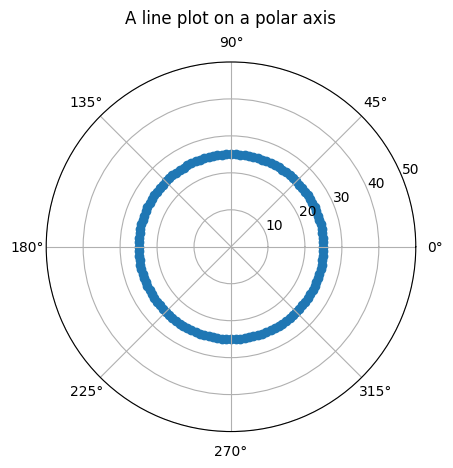

In [1679]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(header_to_int(data_df)*np.pi / 180, dist)
ax.set_rmax(50)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()